# 基於Numba的CUDA Python介紹

- 基於Numba的CUDA Python
- 使用Numba在python中定義

## 什么是 Numba？

Numba是一個用於為CPU和GPU進行數值運算just-in-time的函數編譯器。
函數編譯器: 用來編譯python函數，作為python模組，將普通的函數轉換成執行更快的函數。
以數字計算為主: 目前已處理數值為主，`int`、`float` 和 `complex`。字串的處理目前無法在GPU上取得加速。


### Note：CUDA C/C++、Numba 与 PyCUDA

最常見的CUDA編譯是CUDA C/C++。<br>
**CUDA C/C++**：
- 最常用、高效且最靈活的方式來使用 CUDA
- 加速 C/C++ 應用程序

對於python而言，[PyCUDA](https://documen.tician.de/pycuda/)，是可以支援實現GPU加速的python另一種方式。<br>
**PyCUDA**：
- 完全對街 CUDA C/C++ API
- 在 Python 中釋放 NVIDIA GPU 性能的優先選項
- 需在編寫 C code，通常還要修改 Python code

Numba 是比較簡單的CUDA操作方法，也是本文要介紹的方式<br>
**Numba**：
- 性能也許會低於 PyCUDA
- （目前）尚未完全支援 CUDA C/C++ API
- 仍能大幅加速應用程序，程式碼修改量小
- 開發者可在 Python 框架下輕鬆撰寫程式碼
- 能同时為 CPU 優化 Python 程式碼

## 1 .編譯CPU函數

在介绍 GPU 加速之前，我们首先寫一個函數，然後用 **CPU** 編譯函數。<br>
在python函數我們利用[修飾器](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators)便可以是用numba編譯器，使用十分簡單的語法來修飾python函數，我們直接使用numba的cpu編譯器`@jit`

In [1]:
from numba import jit
import math

# This is the function decorator syntax and is equivalent to `hypot = jit(hypot)`.
# The Numba compiler is just a function you can call whenever you want!
@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x)
    y = abs(y)
    t = min(x, y)
    x = max(x, y)
    t = t / x
    return x * math.sqrt(1+t*t)
print(hypot(3.0, 4.0))
print(hypot.py_func(3.0, 4.0))

5.0
5.0


我們利用[`%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)來測試我們是否真的加速了韓式運算。


In [2]:
%timeit hypot(3.0, 4.0)
%timeit hypot.py_func(3.0, 4.0)

187 ns ± 35.7 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
475 ns ± 25 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


紀錄單次執行時間方式

In [3]:
import time
import numpy as np
@jit
def fun_add(x, y):
    result = np.zeros_like(x)
    for i in range(x.shape[0]):
        result[i] = x[i] + y[i]
    return result
n=1000000
x = np.random.random((n, 1)).astype(np.float32)
y = np.random.random((n, 1)).astype(np.float32)

# 測試 Python 版本
start = time.time()
result_python = fun_add.py_func(x,y)
python_time = time.time() - start
print(f"Python 版本時間: {python_time:.30f} 秒")

# 測試 Numba 版本（第一次執行包含編譯時間）
start = time.time()
result_numba = fun_add(x,y)
numba_time = time.time() - start
print(f"Numba 版本時間 (含編譯): {numba_time:.30f} 秒")

# 再次執行 Numba 版本（僅運行時間）
start = time.time()
result_numba = fun_add(x,y)
numba_time = time.time() - start
print(f"Numba 版本時間 (僅運行): {numba_time:.30f} 秒")

Python 版本時間: 0.926051139831542968750000000000 秒
Numba 版本時間 (含編譯): 0.589339017868041992187500000000 秒
Numba 版本時間 (僅運行): 0.075516700744628906250000000000 秒


Numba 對此函數的加速，從實驗上來看，會比純python實現來的迅速。


####  @jit 的作用
1. Numba 的 @jit：
Numba 的 @jit 裝飾器將 Python 函數編譯為機器碼，並在 CPU 上執行。<br>
JIT（Just-In-Time）編譯是一種在程式執行時將 Python 函數編譯成機器碼的技術。它通過移除 Python 解釋器的開銷（如動態類型檢查）並生成高效的 LLVM 中間碼，顯著提升函數執行速度，特別適合科學計算和數值處理等高效場景。。<br>
底層虛擬機器（Low Level Virtual Machine, LLVM）


2. 運算加速：
hypot 函數執行簡單的數學運算（abs, min, max, math.sqrt），這些運算在 nopython 模式下可以高效編譯。<br>
Numba 將 hypot 編譯為類似 C 的低級程式碼，直接在 CPU 上運行，速度比純 Python 快得多。






### 練習: 蒙地卡羅估算圓周率
通常蒙地卡羅方法透過構造符合一定規則的亂數來解決數學上的各種問題。 <br>
單位圓周長(直徑為1)和單位正方形邊長(邊長為1)總長為$\pi : 4$ <br>
單位圓面積: $半徑\times半徑\times\pi = 0.5\times0.5\times\pi$ <br>
單位正方形面積: $1\times1=1$
$$
\frac{單位圓面積}{單位正方形面積} = \frac{0.5\times0.5\times\pi}{1}
$$

所以我們可以用程式來進行取樣的動作估算面積<br>
透過均勻分布在0~1之間進行長和寬取樣，理論上取樣夠多可以形成一個單位正方形<br>
這時候我們只要估算在單位圓內的點數(圓面積)比上總點數(單位圓面積)
所以
$$
\frac{單位圓內的點數}{總點數} = \frac{0.5\times0.5\times\pi}{1} \rightarrow \pi = 4\times\frac{單位圓內的點數}{總點數} 
$$

1. 請寫一個程式碼，畫出一個從均勻分布(0,1)抽樣10,000資料的散佈圖，並且將單位圓內的點化成紅色，其他則是藍色，見下圖。

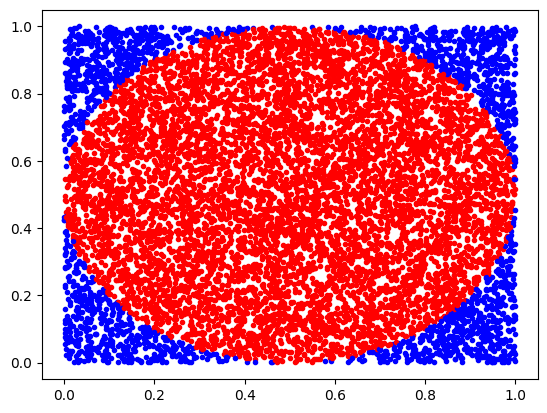

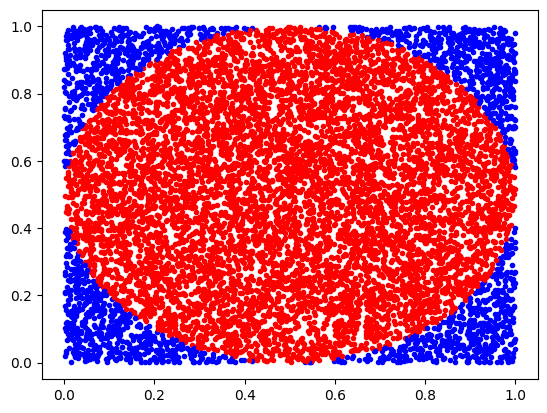

In [4]:
### 在此撰寫
import matplotlib.pyplot as plt
import random
data,labels=[],[]
nsamples=10000
for i in range(nsamples):
    x = random.random()
    y = random.random()
    cx=0.5
    cy=0.5
    if (((x-cx)**2 + (y-cy)**2)**0.5) < 0.5:
        label = 1
    else:
        label = 0
    color = 'b'
    if label == 1:
        color ='r'
    plt.plot(x,y,'.',color=color)

2. 請寫一個計算圓周率估算的python函數(```def monte_carlo_pi(nsamples):```)，並用numba執行。<br>
抽樣數請以100、1,000、10,000、100,000、1,000,000、5,000,000、100,000,000筆資料來估算圓周率，並且跟numpy.pi比較差異值。<br>
輸出預期狀態為<br>

```
numpy pi:3.141592653589793
number of sample:       100, pi:2.76000000, diff:0.3815926536
number of sample:      1000, pi:3.03600000, diff:0.1055926536
number of sample:     10000, pi:3.12600000, diff:0.0155926536
number of sample:    100000, pi:3.14408000, diff:0.0024873464
number of sample:   1000000, pi:3.14248000, diff:0.0008873464
number of sample:   5000000, pi:3.14087680, diff:0.0007158536
number of sample: 100000000, pi:3.14138812, diff:0.0002045336
```

In [5]:
### 在此撰寫
import random
import numpy as np
from numba import jit

@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        # 1/4圓 
        x = random.random()
        y = random.random()
        cx=0.5
        cy=0.5
        if (((x-cx)**2 + (y-cy)**2)**0.5) < 0.5:
            acc += 1
    return 4.0 * acc / nsamples

@jit(nopython=False)
def monte_carlo_pi2(nsamples):
    acc = 0
    for i in range(nsamples):
        # 1/4圓 
        x = random.random()
        y = random.random()
        cx=0.5
        cy=0.5
        if (((x-cx)**2 + (y-cy)**2)**0.5) < 0.5:
            acc += 1
    return 4.0 * acc / nsamples

print('numpy pi:{}'.format(np.pi))
for nsamples in [100,1000,10000,100000,1000000,5000000,100000000]:
    ppi=monte_carlo_pi(nsamples)
    print('number of sample:{:10d}, pi:{:.8f}, diff:{:.10f}'.format(nsamples, ppi, np.abs(ppi-np.pi)))


numpy pi:3.141592653589793
number of sample:       100, pi:3.12000000, diff:0.0215926536
number of sample:      1000, pi:3.14000000, diff:0.0015926536
number of sample:     10000, pi:3.15160000, diff:0.0100073464
number of sample:    100000, pi:3.13468000, diff:0.0069126536
number of sample:   1000000, pi:3.14029200, diff:0.0013006536
number of sample:   5000000, pi:3.14188800, diff:0.0002953464
number of sample: 100000000, pi:3.14171504, diff:0.0001223864


3. 利用%timeite估計和純python的時間差異。設定nsamples=10,000

In [6]:
### 在此撰寫
nsamples=10000
%timeit monte_carlo_pi(nsamples) 
%timeit monte_carlo_pi.py_func(nsamples) 

%timeit monte_carlo_pi2(nsamples) 
%timeit monte_carlo_pi2.py_func(nsamples) 

98.8 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
3.44 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
99 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
3.49 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## object 和 nopython 模式

Numba 在一般運行總共分為兩種模式一種是nopython mode，另一種是 object mode。

1. nopython mode（(@jit(nopython=True)): 預設 nopython=True，這意味著它會嘗試將函數完全編譯為機器碼，指示編譯器盡可能產生沒有Python 物件的純本機機器碼。在這種模式下，Numba 會嘗試對函數進行完全靜態編譯，避免使用Python C API，以獲得更高的效能。<br>
nopyhon mode:在執行第二次會直接忽略 python C API，這種方式的好處在於加速的非常快，會比 object mode 快大概 20~30 倍之多。


2. object mode(@jit(nopython=False)): 在執行時雖然比 nopython 來的慢，但是錯誤率較低，不需要花大量的時間 debug，因此若是專案有時間的限制，可先考慮使用這種版本。


JIT 小結論1: 效能最佳化：使用@jit(nopython=True)裝飾器可以顯著提升函數的執行效率，特別是對於數值密集的運算任務，如陣列操作、循環等。<br>
JIT 小結論2: 程式碼最佳化：Numba 在編譯過程中會嘗試進行多種最佳化，例如類型推斷、循環展開和向量化操作，以進一步提高程式碼的運行速度。<br>
JIT 小結論3: 靜態類型：要求函數中的所有變數都具有明確的靜態類型，這樣編譯器可以有效地產生高效率的機器碼。因此，在使用@jit(nopython=True)時，通常需要注意避免使用Python 中的動態特性和物件<br>


In [7]:
import numpy as np
from numba import jit
import time

# 純 Python 版本
def sum_list_python(lst):
    total = 0
    for item in lst:
        total += item
    return total

# 使用 object 模式的 Numba 版本
@jit(nopython=False)  # 顯式設置 nopython=False，啟用 object 模式
def sum_list_object_mode(lst):
    total = 0
    for item in lst:
        total += item
    return total

# 改進：使用 NumPy 陣列以支援 nopython 模式
@jit(nopython=True)
def sum_array_nopython(arr):
    total = 0
    for item in arr:
        total += item
    return total

# 測試程式碼
lst = list(range(1_000_000))  # Python 列表
arr = np.array(lst, dtype=np.int32)  # NumPy 陣列

# 測試純 Python 版本
start = time.time()
result_python = sum_list_python(lst)
python_time = time.time() - start
print(f"純 Python 版本時間: {python_time:.4f} 秒")

# 測試 object 模式
start = time.time()
result_object = sum_list_object_mode(lst)
object_time = time.time() - start
print(f"Object 模式時間(第一次要編譯): {object_time:.4f} 秒")
start = time.time()
result_object = sum_list_object_mode(lst)
object_time = time.time() - start
print(f"Object 模式時間: {object_time:.4f} 秒")

# 測試 nopython 模式（使用 NumPy 陣列）
start = time.time()
result_array = sum_array_nopython(arr)
array_time = time.time() - start
print(f"Nopython 模式（NumPy 陣列）時間(第一次要編譯): {array_time:.4f} 秒")
start = time.time()
result_array = sum_array_nopython(arr)
array_time = time.time() - start
print(f"Nopython 模式（NumPy 陣列）時間: {array_time:.15f} 秒")

# 驗證結果
print("結果是否一致:", result_python == result_object == result_array)

純 Python 版本時間: 0.0357 秒
Object 模式時間(第一次要編譯): 1.2131 秒
Object 模式時間: 1.2216 秒
Nopython 模式（NumPy 陣列）時間(第一次要編譯): 0.0510 秒
Nopython 模式（NumPy 陣列）時間: 0.000000000000000 秒
結果是否一致: True


**Numba主要是執行數值相關的函數，如果函數Numba不支援會出現什麼問題? <br>
範例：混合 Python 物件與數值運算 <br>
以下範例展示 object 模式如何處理混合場景，例如使用 Python 字典（不支援 nopython 模式）與數值運算。<br>



In [8]:
# @jit
@jit(nopython=False)
# @njit
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\2363528781.py (2)[0m
[1m
File "C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\2363528781.py", line 2:[0m
[1m# @jit
[1m@jit(nopython=False)
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dict'>[0m


In [9]:
from numba import jit
import time

@jit(nopython=False)
def dict_and_math(d, x):
    total = 0
    for key in d:  # 遍歷字典鍵
        total += d[key] * x
    return total

d = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
x = 2.5

start = time.time()
result_object = dict_and_math(d, x)
object_time = time.time() - start
print(f"Object 模式時間: {object_time:.4f} 秒")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\3732333174.py (4)[0m
[1m
File "C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\3732333174.py", line 4:[0m
[1m
[1m@jit(nopython=False)
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dict'>[0m


In [10]:
from numba import jit
from numba.typed import Dict
from numba import types
import time

# 使用 numba.typed.Dict
@jit(nopython=True)
def typed_dict_and_math(d, x):
    total = 0.0
    for key in d:
        total += d[key] * x
    return total

# 測試程式碼
# 創建類型化字典
d = Dict.empty(key_type=types.unicode_type, value_type=types.float32)
d['a'] = 1.0
d['b'] = 2.0
d['c'] = 3.0
d['d'] = 4.0
x = 2.5

# 測試 Numba nopython 模式
start = time.time()
result_numba = typed_dict_and_math(d, x)
numba_time = time.time() - start
print(f"Numba nopython 模式時間: {numba_time:.4f} 秒")

# 驗證結果
print("結果是否一致:", result_python == result_numba)
print("結果:", result_numba)

c:\Users\glanb\anaconda3\Lib\site-packages\numba\typed\typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from float64 to float32. Precision may be lost.
  d[key] = value


Numba nopython 模式時間: 0.2045 秒
結果是否一致: False
結果: 25.0


**Numba 的支援範圍：<br>
object 模式支援簡單的 Python 物件（如列表、元組），但對 Python 字典的支援非常有限。<br>
字典的動態鍵值對（特別是鍵為字符串）超出了 Numba 的類型推斷能力。<br>

------------
#### @jit(nopython=True)簡化
直接改用@njit

In [11]:
import numpy as np
from numba import jit, njit
import time


# 使用 object 模式的 Numba 版本
@jit(nopython=True)  # 顯式設置 nopython=False，啟用 object 模式
def sum_list_jit_mode(lst):
    total = 0
    for item in lst:
        total += item
    return total

# 改進：使用 NumPy 陣列以支援 nopython 模式
@njit
def sum_list_njit_mode(lst):
    total = 0
    for item in lst:
        total += item
    return total

# 測試程式碼
lst = list(range(1_000_000))  # Python 列表

# 測試 object 模式
start = time.time()
result_object = sum_list_jit_mode(lst)
object_time = time.time() - start
print(f"jit 模式時間(第一次要編譯): {object_time:.4f} 秒")
start = time.time()
result_object = sum_list_jit_mode(lst)
object_time = time.time() - start
print(f"jit 模式時間: {object_time:.4f} 秒")

# 測試 nopython 模式（使用 NumPy 陣列）
start = time.time()
result_array = sum_list_njit_mode(lst)
array_time = time.time() - start
print(f"njit 模式（NumPy 陣列）時間(第一次要編譯): {array_time:.4f} 秒")
start = time.time()
result_array = sum_list_njit_mode(lst)
array_time = time.time() - start
print(f"njit 模式（NumPy 陣列）時間: {array_time:.15f} 秒")


jit 模式時間(第一次要編譯): 1.1870 秒
jit 模式時間: 1.0825 秒
njit 模式（NumPy 陣列）時間(第一次要編譯): 1.1541 秒
njit 模式（NumPy 陣列）時間: 1.096629858016968 秒


--------------
## NumPy的Universal functions(ufunc)

In [12]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])
print('a:',a)
print('b:',b)

print('a+b:', np.add(a, b)) # Returns a new NumPy array resulting from adding every element in `a` to every element in `b`

print('a+100:', np.add(a, 100)) # Returns a new NumPy array resulting from adding 100 to every element in `a`

c = np.arange(4*4).reshape((4,4))
print('c:\n', c)
print('a+c:', np.add(a, c))  # Python Broadcast


a: [1 2 3 4]
b: [10 20 30 40]
a+b: [11 22 33 44]
a+100: [101 102 103 104]
c:
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
a+c: [[ 1  3  5  7]
 [ 5  7  9 11]
 [ 9 11 13 15]
 [13 15 17 19]]


## 為GPU建立ufunc

在numba上，只需要進行函數裝飾即可，使用的方式是 Numba 的 `@vectorize`



In [13]:
from numba import vectorize
import numpy as np
@vectorize
def add_ten(num):
    return num + 10 # This scalar operation will be performed on each element

nums = np.arange(10)
add_ten(nums) # pass the whole array into the ufunc, it performs the operation on each element

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int64)

In [14]:
@vectorize
def add_ufunc(x, y):
    return x + y
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])
c = np.arange(4*4).reshape((4,4))

add_ufunc(b, c)

array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]], dtype=int64)

In [15]:
%timeit np.add(b, c)   
%timeit add_ufunc(b, c) 

1.05 µs ± 32.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.77 µs ± 34.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


指定輸入和輸出的資料型態
```
from numba import vectorize

@vectorize([return_type(arg1_type, arg2_type, ...)], target='cpu')  # 預設 target='cpu'
def function_name(arg1, arg2, ...):
    # 標量運算
    return result
```

return_type(arg1_type, arg2_type, ...)：<br>
指定輸入和輸出的資料類型，例如 float32(float32, float32) 表示輸入兩個 32 位浮點數，輸出一個 32 位浮點數。<br>
支援類型：int32, int64, float32, float64 等。



In [16]:
import numpy as np
from numba import vectorize
import time

# 使用 @vectorize 實現逐元素加法
@vectorize(['float32(float32, float32)'])
def add_vectorized(x, y):
    return x + y

# 測試程式碼
n = 1_000_000
a = np.random.random(n).astype(np.float32)
b = np.random.random(n).astype(np.float32)

# 測試 NumPy 版本
start = time.time()
result_numpy = np.add(a, b)  # 使用 NumPy 的 ufunc
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.10f} 秒")


# 測試 Numba vectorize 版本
start = time.time()
result_vectorized = add_vectorized(a, b)
vectorized_time = time.time() - start
print(f"Numba vectorize 版本時間: {vectorized_time:.10f} 秒")



NumPy 版本時間: 0.0009968281 秒
Numba vectorize 版本時間: 0.0009975433 秒


In [17]:
%timeit np.add(a, b)   
%timeit add_vectorized(a, b) 

1.26 ms ± 69.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.39 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
@vectorize(['int64(int64, int64)']) # Type signature and target are required for the GPU
def add_ufunc(x, y):
    return x + y
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])
add_ufunc(a, b)

array([11, 22, 33, 44], dtype=int64)

指定運算設備
*target：
- target='cpu'：在 CPU 上向量化執行（預設）。
- target='cuda'：在 GPU 上並行執行（需支援 CUDA 的 GPU）。
- target='parallel'：在 CPU 上多執行緒並行執行（需要額外設置）。

In [19]:
import numpy as np
from numba import vectorize, cuda
import time

# 使用 @vectorize 在 GPU 上計算平方根
@vectorize(['float32(float32)'], target='cuda')
def sqrt_vectorized(x):
    return x ** 0.5  # 平方根，等價於 math.sqrt(x)

# 測試程式碼
n = 1_000_000
a = np.random.random(n).astype(np.float32)

# 傳輸到 GPU
a_device = cuda.to_device(a)
out_device = cuda.device_array(n, dtype=np.float32)

# 測試 NumPy 版本
start = time.time()
result_numpy = np.sqrt(a)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")

# 測試 Numba CUDA vectorize 版本
start = time.time()
out_device = sqrt_vectorized(a_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"Numba CUDA vectorize 版本時間: {cuda_time:.4f} 秒")

# 複製結果回主機
result_cuda = out_device.copy_to_host()

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda))

NumPy 版本時間: 0.0010 秒
Numba CUDA vectorize 版本時間: 0.1321 秒
結果是否一致: True


In [20]:
import numpy as np
from numba import vectorize, cuda
import time

# 使用 @vectorize 在 GPU 上計算平方根
@vectorize(['float32(float32)'], target='cuda')
def sqrt_vectorized(x):
    return np.sqrt(x)

# 測試程式碼
n = 1_000_000
a = np.random.random(n).astype(np.float32)

# 傳輸到 GPU
a_device = cuda.to_device(a)
out_device = cuda.device_array(n, dtype=np.float32)


# 測試 Numba CUDA vectorize 版本
start = time.time()
out_device = sqrt_vectorized(a_device)
cuda.synchronize()
cuda_time = time.time() - start


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.sqrt' or unsupported use of the function.
[1m
File "C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\2906023912.py", line 8:[0m
[1mdef sqrt_vectorized(x):
[1m    return np.sqrt(x)
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\2906023912.py (8)[0m
[1m
File "C:\Users\glanb\AppData\Local\Temp\ipykernel_42792\2906023912.py", line 8:[0m
[1mdef sqrt_vectorized(x):
[1m    return np.sqrt(x)
[0m    [1m^[0m[0m


GPU 模式（target='cuda'）：避免使用 numpy 函數（如 np.sqrt），改用 math 模組（如 math.sqrt），因為 Numba CUDA 不支援大部分 NumPy 函數。

練習: 較複雜的運算: 高斯函數
$$
\frac{1}{\sqrt{2\pi}\sigma} e^{\frac{(x-\mu)^2}{2\sigma^2}}
$$

In [21]:
import math # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy
import numpy as np


SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test on a single element just to make sure it works
gaussian_pdf(x[0], 0.0, 1.0)

c:\Users\glanb\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([0.02070536], dtype=float32)

In [22]:
import scipy.stats # for definition of gaussian distribution, so we can compare CPU to GPU time
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

34.5 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit gaussian_pdf(x, mean, sigma)

3.86 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
@vectorize
def cpu_gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)
%timeit cpu_gaussian_pdf(x, mean, sigma)

9.08 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


用法：
- 使用 @vectorize 定義標量函數，指定類型簽名，選擇 target（cpu 或 cuda）。
- 適用於元素級運算，自動向量化並行執行。

時機：
- 簡單的逐元素運算、大數據量、自訂 ufunc。
- 不適合複雜邏輯、小數據量或動態資料結構。


與 @jit 的區別：<br>
- @jit 編譯整個函數，適合複雜邏輯（例如迴圈、條件）。
- @vectorize 專注於元素級運算，適合簡單的標量計算，自動向量化並行。


------
ufunc適合元素級的計算，在數值運算也常見，但當GPU編譯的函數非元素級的向量化函數，我們可以用numba.cuda.jit來執行。


In [25]:
from numba import cuda
import numpy as np

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1) # We can use device functions inside our GPU ufuncs
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

n = 1000000
rho1 = np.random.random(n).astype(np.float32)
theta1 = np.random.random(n).astype(np.float32)
rho2 = np.random.random(n).astype(np.float32)
theta2 = np.random.random(n).astype(np.float32)

# 傳輸到 GPU
rho1_device = cuda.to_device(rho1)
theta1_device = cuda.to_device(theta1)
rho2_device = cuda.to_device(rho2)
theta2_device = cuda.to_device(theta2)

# 計算距離
distances = polar_distance(rho1_device, theta1_device, rho2_device, theta2_device)
print(distances)

print(distances.copy_to_host())


[0.481047   0.3946376  0.18389662 ... 0.20106353 0.7159261  0.6361072 ]


# 練習:
我們利用GPU來加速"零抑制"函式。將波形低於閾值(threshold)則設定為0。

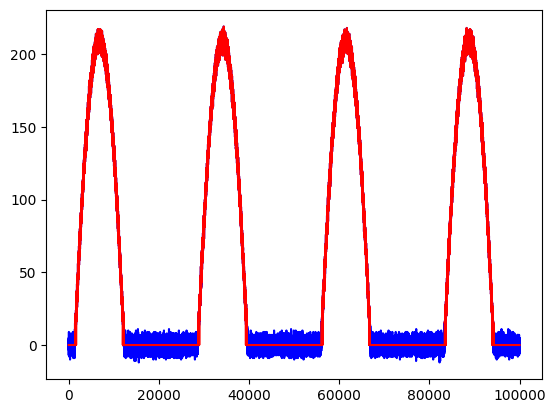

In [26]:
# This allows us to plot right here in the notebook
%matplotlib inline
from matplotlib import pyplot as plt
from numba import vectorize

@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform,'b')

waveform2 = zero_suppress(waveform, 15)
plt.plot(waveform2,'r')


# GPU管理
我們雖然用了Numba來執行GPU運算，但實際上我們數值是在CPU上的numpy來產生數值，然後在將此CPU的numpy數值作為GPU函數的輸入和輸出。<br>
因為numba為了簡化會自動將數據從CPU傳到GPU來運算然後再將數值傳回CPU<br>
每次運算資料流: CPU→GPU→CPU  搬移了兩次<br>

但實務上我們的運算有可能都在用GPU來處理，這樣數據一值在CPU和GPU之間搬移，非常占用記憶體頻寬。<br>

所以最好的處理方式是減少CPU(Host)和GPU(Device)之間的數據傳輸<br>

一開始就將數據搬到GPU，然後後續的處理都在GPU來做，直到最後處理完成在搬回CPU<br>


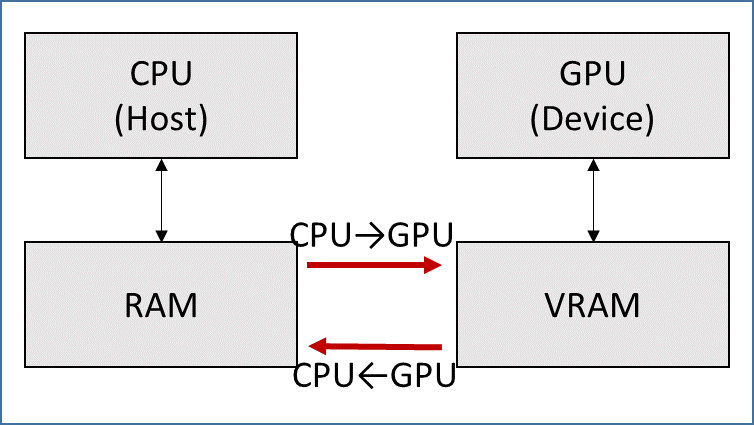

此sample函數運算是: 
CPU(x,y)→GPU(add_ufunc)→CPU(x,y) 

In [27]:
from numba import vectorize

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
z=add_ufunc(x, y)
print(type(z))

%timeit add_ufunc(x, y)  # Baseline performance with host arrays

<class 'numpy.ndarray'>
1.69 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


此sample函數運算是: 
CPU(x,y)→GPU(x,y)→GPU(add_ufunc)

In [28]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device) # 看不到數值
print(x_device.shape)
print(x_device.dtype)
%timeit add_ufunc(x_device, y_device)

(100000,)
float32
388 µs ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


上面的寫法，add_ufunc 函數使用 Numba 的 CUDA 向量化的通用函數 (ufunc) 在 GPU 上執行。<br>
輸入陣列 x_device 和 y_device 已位於 GPU 上，計算結果會儲存在 Numba 自動為輸出分配的新 GPU 陣列中。<br>
每次執行 ufunc 時都會"重新建立建這個輸出陣列"<br>

有沒有辦法優化這類型的問題<br>
直接分配了一個 GPU 陣列 out_device 來儲存計算結果。<br>
add_ufunc 函數直接將結果寫入這個預分配的陣列，而不是每次執行都創建一個新陣列。<br>

In [29]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()
%timeit add_ufunc(x_device, y_device, out=out_device)

212 µs ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


預先宣告變數來儲存輸出可以避免在每次執行時重複分配 GPU 記憶體→這種優化對於需要頻繁執行的 GPU 計算任務尤其重要。<br>
下面我們也呈現如何將GPU資料轉回CPU來用。

In [30]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


## 練習

In [31]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

out_pulses = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()
out_waveform = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

make_pulses(t, period, 100.0, out=out_pulses)
add_ufunc(out_pulses, noise, out=out_waveform)

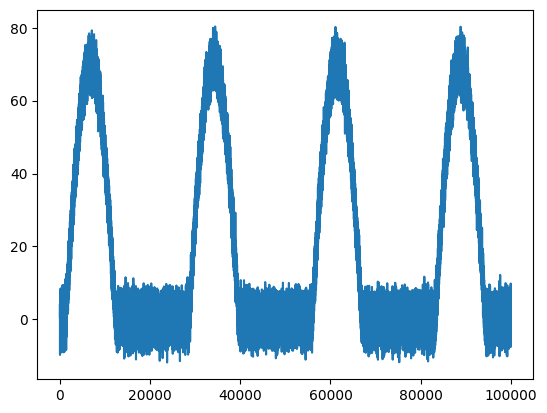

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(out_waveform.copy_to_host())

---------------
# GPU 的特性

- 能有效率地啟動大量執行緒。
- 會平行地運行大量執行緒。

https://www.youtube.com/shorts/vGWoV-8lteA



# 使用 @cuda.jit 手寫核心
放棄 @vectorize，使用 @cuda.jit 手寫 CUDA 核心，手動分配執行緒並處理多返回值。

## 執行緒 (threads)
以執行程式碼與儲存少量的狀態 (state)，因此每個執行緒都具備固定大小的區域記憶體 (local memory) 供其調用。


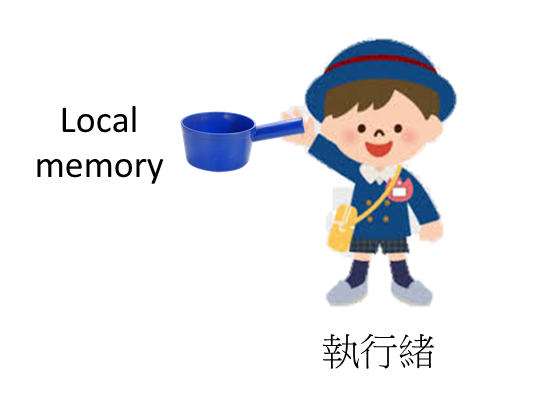

## 區塊 (blocks)

一群執行緒就稱為區塊

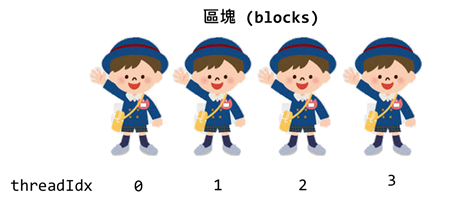


代表的意義就是一起合作解決子任務的執行緒們，每個執行緒就透過 threadIdx (區域變數)讓執行緒知道自己在Block中的哪個位置，因此我們可以明確指派每個執行緒應該負責的部分。

CUDA 有支援了2D 與3D區塊 ，下圖為 2D 區塊，從```threadIdx.x```和```threadIdx.y```來操作

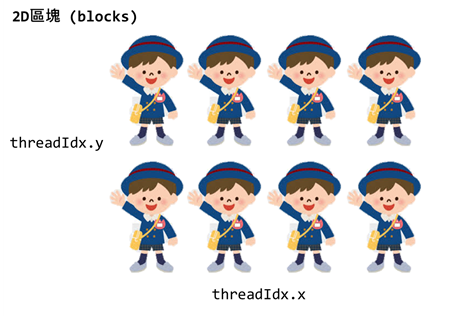


同一個區塊的執行緒可以透過共享記憶體 (shared memory) 進行交流，該區塊中的執行緒才能讀取與寫入這個固定大小的記憶體。


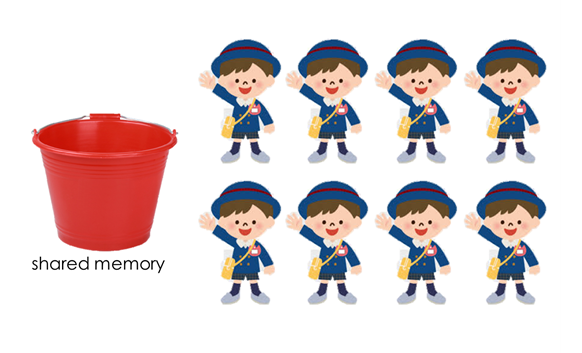





# 網格 (Grids)
多個區塊的組合就稱為網格 (同樣支援 1D、2D 與 3D 結構)，其中每個區塊的大小都相同，且都有各自的共享記憶體

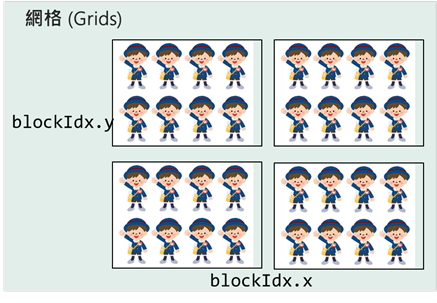



## GPU與執行緒、區塊、網格之間關係

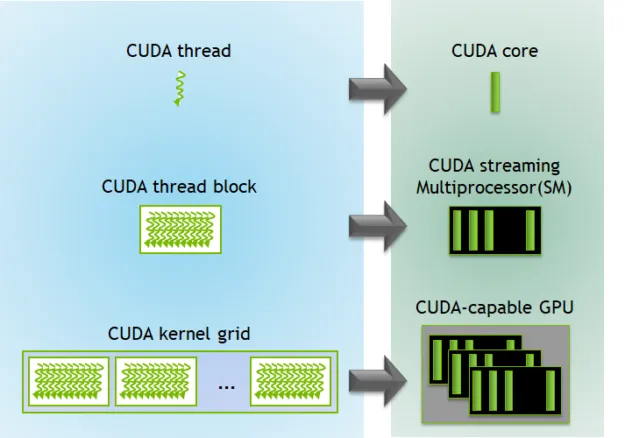

https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/


In [33]:
from numba import cuda
import numpy as np

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1) # We can use device functions inside our GPU ufuncs
    x2, y2 = polar_to_cartesian(rho2, theta2)
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5


跟前面Numba介紹不太一樣，這邊要啟動需要先設定好 block 與 grid 後再啟動它：

* 一維陣列

In [34]:
import numpy as np
from numba import cuda
import math
import time


n = 1_000_000
rho = np.random.random(n).astype(np.float32)
theta = np.random.random(n).astype(np.float32)

# 傳輸到 GPU (輸入和輸出的記憶體要先給定)
rho_device = cuda.to_device(rho)
theta_device = cuda.to_device(theta)
x_out_device = cuda.device_array(n, dtype=np.float32)
y_out_device = cuda.device_array(n, dtype=np.float32)


# 手寫 CUDA 核心
@cuda.jit
def polar_to_cartesian_kernel(rho, theta, x_out, y_out):
    idx = cuda.grid(1)
    '''
    執行緒分配： idx = cuda.grid(1) 獲取全局執行緒索引（一維）。
    每個執行緒處理一個元素，例如執行緒 idx 計算 x_out[idx] 和 y_out[idx]。
    '''
    if idx < rho.shape[0]: # 邊界檢查：確保執行緒不越界，僅處理有效元素（idx < 1_000_000）
        x_out[idx] = rho[idx] * math.cos(theta[idx])
        y_out[idx] = rho[idx] * math.sin(theta[idx])

# 網格與區塊配置
'''
每個區塊有 256 個執行緒，這是 CUDA 的常見設置，適合大多數 GPU（例如 NVIDIA GPU 的 warp 大小為 32，256 是其倍數）
''' 
threadsperblock = 256
blockspergrid = (n + threadsperblock - 1) // threadsperblock # 確保網格覆蓋所有元素
print('blockspergrid:{}'.format(blockspergrid))
print('blockspergrid*threadsperblock:{}'.format(blockspergrid*threadsperblock))
# 總執行緒數為 3907 * 256 = 1_000_192，略多於 1,000,000，邊界檢查確保不越界。
# 每個執行緒處理一個元素，總共 1,000,000 個元素由 1,000,000 個執行緒並行計算。

# 執行 CUDA 核心 
# 執行 1,000,000 個執行緒並行計算
start = time.time()
polar_to_cartesian_kernel[blockspergrid, threadsperblock](rho_device, theta_device, x_out_device, y_out_device)
cuda.synchronize() # 確保 GPU 計算完成，否則後續操作（例如複製結果）可能讀取未完成數據。
cuda_time = time.time() - start
print(f"CUDA 版本時間: {cuda_time:.4f} 秒")

# 複製結果回主機
x_out = x_out_device.copy_to_host()
y_out = y_out_device.copy_to_host()

blockspergrid:3907
blockspergrid*threadsperblock:1000192
CUDA 版本時間: 0.0666 秒


 * 二維陣列

In [35]:
import numpy as np
from numba import cuda

# 輸入與輸出陣列
n= 5 
data = np.random.random((n, n)).astype(np.float32)
out = np.zeros((n, n), dtype=np.float32)  # 初始化輸出陣列

# 傳輸到 GPU
data_device = cuda.to_device(data)
out_device = cuda.to_device(out)


# 定義 device 函數
@cuda.jit(device=True)
def add(a, b):
    return a + b

# 定義 CUDA 核心
@cuda.jit
def my_func(input, out):
    # 執行緒分配：獲取全局索引 idx = cuda.grid(1)
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # 計算全局行索引。
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y # 計算全局列索引。
    # 邊界檢查
    if x < out.shape[0] and y < out.shape[1]: # 確保執行緒不會訪問陣列邊界外的元素，防止潛在的記憶體錯誤
        out[x, y] = add(input[x, y], 10)


# 配置網格和區塊
'''
1. 每個區塊(block)設定執行緒數量
   threadsperblock = (3, 3)。
2. 計算網格(grid)大小，依據預計的運算矩陣大小來估計：
   blockspergrid_x = (5 + 3 - 1) // 3 = 2
   blockspergrid_y = (5 + 3 - 1) // 3 = 2
   grid: (2,2)
總執行緒數為 (2*3, 2*3) = (6, 6) = 36個執行緒，足以覆蓋 (5, 5)。
'''
threadsperblock = (3, 3)  # 更合理的區塊大小,每個區塊有 3x3=9 個執行緒
blockspergrid_x = (data.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (data.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)


# 執行 CUDA 核心
my_func[blockspergrid, threadsperblock](data_device, out_device)
cuda.synchronize()

# 複製結果回主機
result = out_device.copy_to_host()

# 驗證結果
expected = data + 10
print("結果是否一致:", np.allclose(result, expected))
# print('original data: \n x= \n' , data)
# print('GPU: x+10 = \n', result)
# print('CPU: x+10 = \n', expected)

結果是否一致: True


c:\Users\glanb\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## 範例: 使用 Numba 的 CUDA 功能來計算兩個多維矩陣相乘。

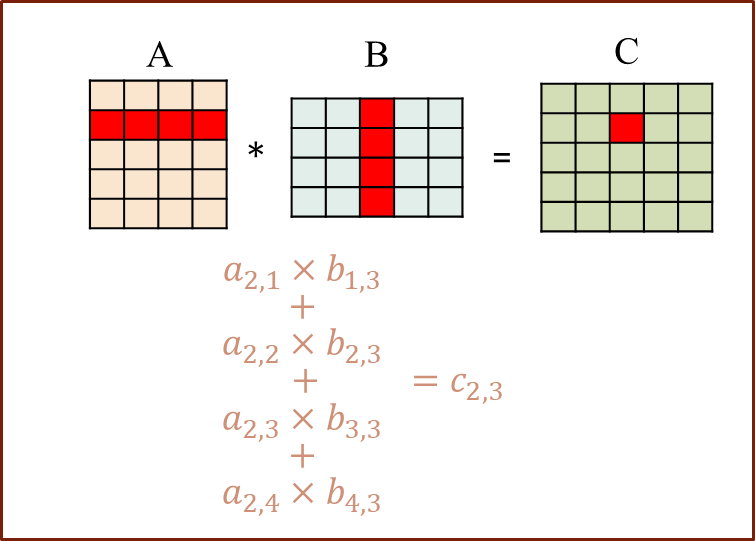

對於形狀為 (batch_size, n, n) 的矩陣 a 和 b，每個批次 i 計算：<br>

```c[i, j, k] = sum(a[i, j, m] * b[i, m, k]) for all m```

假設n=512<br>
a: (3,512,512)<br>
b: (3,512,512)<br>
c= a*b :(3,512,512)<br>


### 圖示法
a: (3,9,9)<br>
b: (3,9,9)<br>
c= a*b :(3,9,9)<br>
網格和區塊配置：<br>
- 區塊(Block)大小：block_dim = (3, 3)。<br>
- 網格(grid)大小： grid_dim = ((9 + 2) // 3, (9 + 2) // 3, 3) = (3, 3, 3)。<br>
總執行緒數(3x3,3x3,3)=(9,9,3)足以覆蓋所有輸出元素。

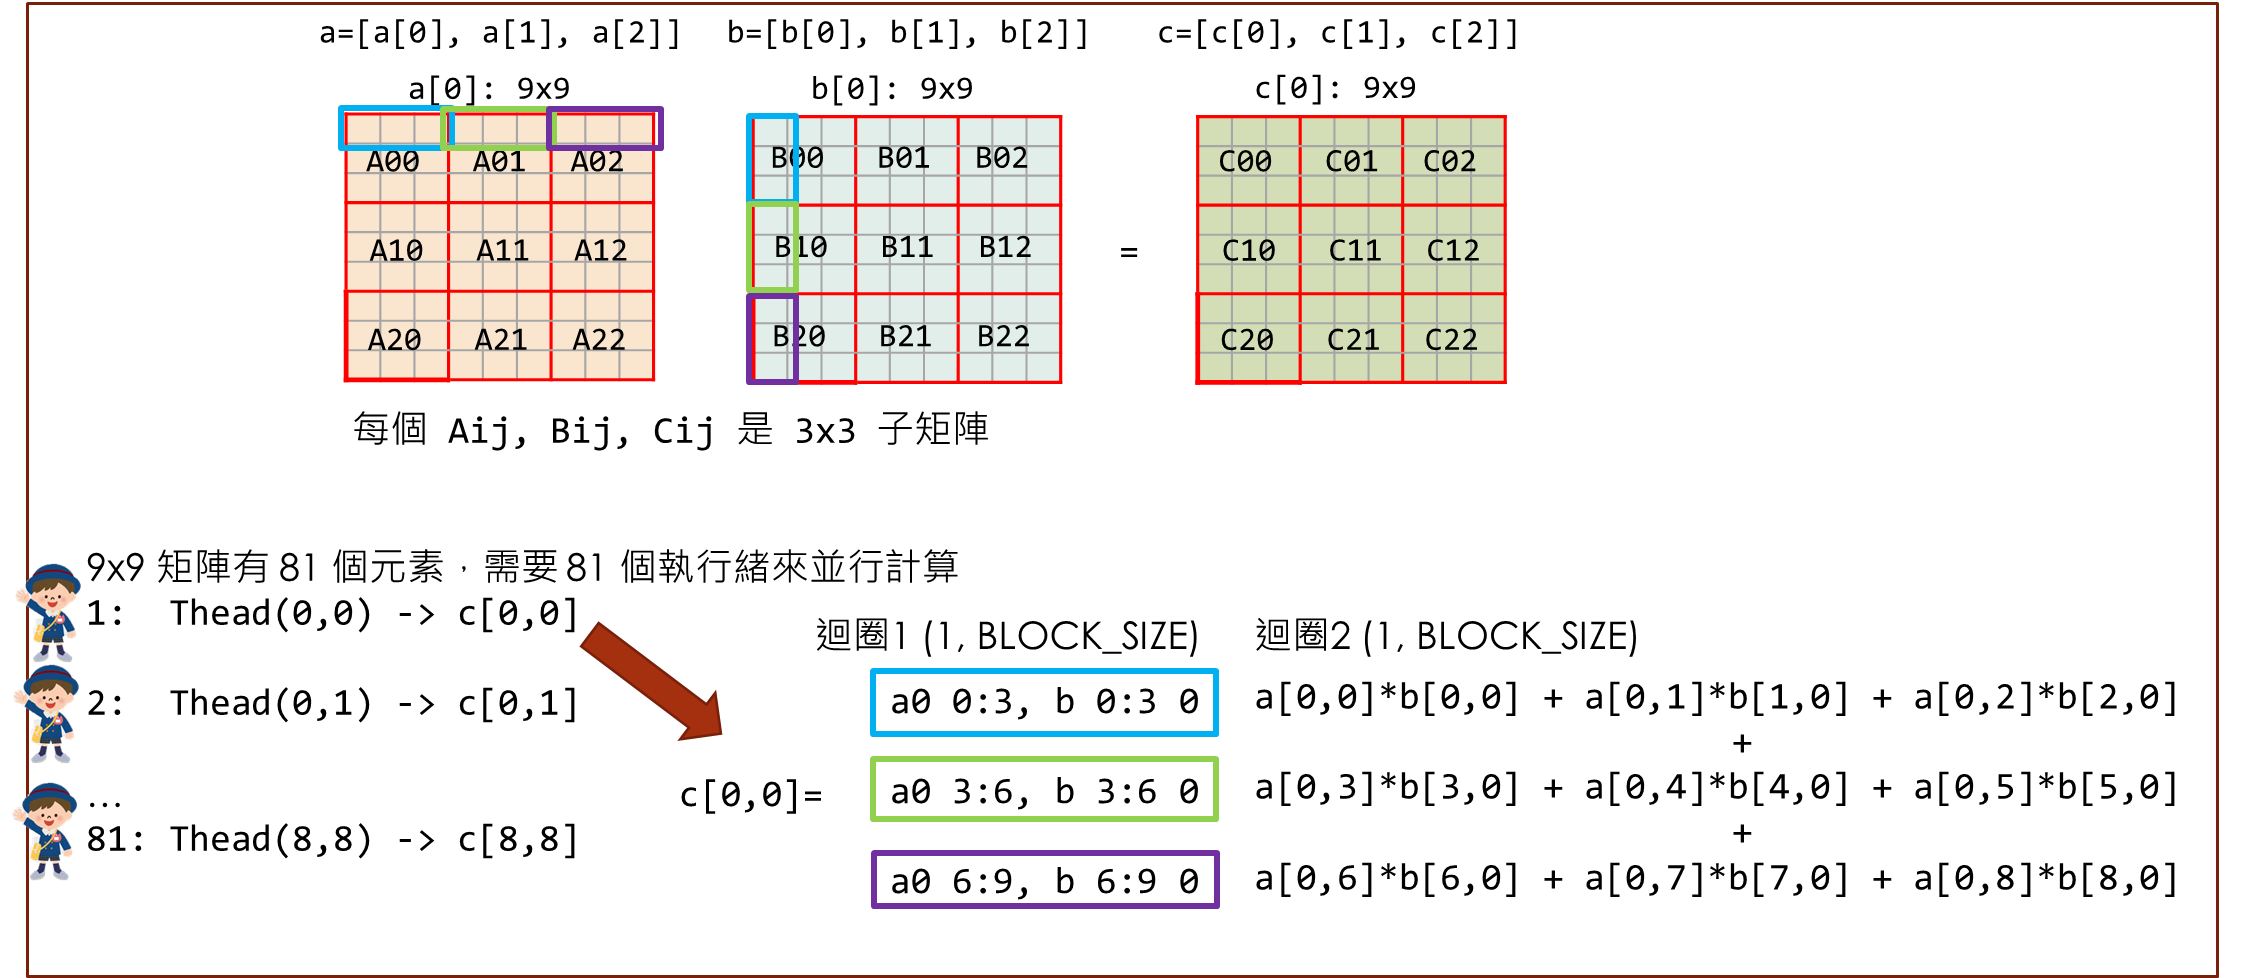


### 網格和區塊配置：
- 區塊(Block)大小：block_dim = (16, 16)，每個區塊 256 個執行緒。
- 網格(grid)大小：
   grid_dim = ((n + 16 - 1) // 16, (n + 16 - 1) // 16, batch_size)：
   * x, y 維度：(512 + 15) // 16 = 32，覆蓋 512x512。
   * z 維度：batch_size = 3，每個批次一個網格。
   * grid_dim = (32, 32, 3)
總執行緒數(32x16, 32x16, 3)足以覆蓋所有輸出元素。



------------------
1. 分塊策略：
    - 將 512x512 矩陣分割為 16x16 的子矩陣（BLOCK_SIZE = 16）。
    - 每個 CUDA 區塊計算輸出矩陣 c 的一個 16x16 子矩陣。
2. 共享記憶體：
    - 分配兩個 16x16 的共享記憶體陣列（a_shared, b_shared），暫存 a 和 b 的子矩陣。
    - 每個執行緒載入一個元素到共享記憶體，檢查邊界以避免越界。
3. 索引：
    - batch = cuda.blockIdx.z：批次索引（0, 1, 2）。
    - global_row = cuda.blockIdx.x * BLOCK_SIZE + cuda.threadIdx.x：全局行索引。
    - global_col = cuda.blockIdx.y * BLOCK_SIZE + cuda.threadIdx.y：全局列索引。
4. 計算：
    - 每個執行緒計算 c[batch, global_row, global_col]，通過迴圈累加子矩陣乘積。
    - 使用 cuda.syncthreads() 確保共享記憶體載入和計算同步。
5. 範圍檢查：
    - 確保 batch < c.shape[0] 和 global_row, global_col 在範圍內。


In [36]:
import numpy as np
from numba import cuda
import time

BLOCK_SIZE = 16

# NumPy 版本
def matrix_multiply_numpy(a, b):
    return np.matmul(a, b)

# CUDA 版本（分塊矩陣乘法）
@cuda.jit
def matrix_multiply_cuda(a, b, c):
    
    # 獲取執行緒和區塊索引 執行緒索引
    row = cuda.threadIdx.x # 區塊內部的行索引（0 到 BLOCK_SIZE-1）。
    col = cuda.threadIdx.y # 區塊內部的行索引（0 到 BLOCK_SIZE-1）。
    batch = cuda.blockIdx.z # 表示當前處理的批次（0, 1, 2，假設 batch_size = 3）
    
    # 計算全局索引 (區塊索引blockIdx)
    global_row = cuda.blockIdx.x * BLOCK_SIZE + row # 範圍：0 到 8（對應 c 的 9 行，假設c=(3,9,9))
    global_col = cuda.blockIdx.y * BLOCK_SIZE + col # 範圍：0 到 8（對應 c 的 9 列，假設c=(3,9,9)）
    '''
    每個執行緒負責計算 c[batch, global_row, global_col] 的一個元素。
    全局索引將區塊內的local執行緒映射到整個 9x9 矩陣。
    '''
    # 檢查是否在矩陣範圍內
    if batch < c.shape[0] and global_row < c.shape[1] and global_col < c.shape[2]:
        # 分配共享記憶體 分配兩個 16x16 的共享記憶體陣列（a_shared, b_shared），暫存子矩陣。
        a_shared = cuda.shared.array((BLOCK_SIZE, BLOCK_SIZE), dtype=np.float32)
        b_shared = cuda.shared.array((BLOCK_SIZE, BLOCK_SIZE), dtype=np.float32)
        
        tmp = 0.0
        # 沿著 k 維度分塊
        for block_k in range(0, a.shape[2], BLOCK_SIZE):
            # 載入子矩陣到共享記憶體
            a_shared[row, col] = a[batch, global_row, block_k + col] if block_k + col < a.shape[2] else 0.0
            b_shared[row, col] = b[batch, block_k + row, global_col] if block_k + row < b.shape[2] else 0.0
            
            # 同步執行緒，確保共享記憶體載入完成
            cuda.syncthreads() # 確保執行緒協作正確，否則可能出現資料競爭。
            
            # 計算當前塊的貢獻
            for k in range(BLOCK_SIZE):
                tmp += a_shared[row, k] * b_shared[k, col]
            
            # 同步執行緒，準備下一次載入
            cuda.syncthreads()
        
        # 寫入結果
        c[batch, global_row, global_col] = tmp

# 測試程式碼
batch_size = 3
n = 512
a = np.random.random((batch_size, n, n)).astype(np.float32)
b = np.random.random((batch_size, n, n)).astype(np.float32)
c = np.zeros((batch_size, n, n), dtype=np.float32)

# 傳輸到 GPU
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
c_device = cuda.to_device(c)

# 配置網格和區塊
block_dim = (BLOCK_SIZE, BLOCK_SIZE)  # 16x16 執行緒
grid_dim = ((n + BLOCK_SIZE - 1) // BLOCK_SIZE, (n + BLOCK_SIZE - 1) // BLOCK_SIZE, batch_size)

# 測試 NumPy 版本
start = time.time()
result_numpy = matrix_multiply_numpy(a, b)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")

# 測試 CUDA 版本
start = time.time()
matrix_multiply_cuda[grid_dim, block_dim](a_device, b_device, c_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間(含編譯): {cuda_time:.4f} 秒")


# 測試 CUDA 版本
start = time.time()
matrix_multiply_cuda[grid_dim, block_dim](a_device, b_device, c_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間(僅運行): {cuda_time:.4f} 秒")

# 複製結果回主機
result_cuda = c_device.copy_to_host()

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda))

NumPy 版本時間: 0.0044 秒
CUDA 版本時間(含編譯): 0.3274 秒
CUDA 版本時間(僅運行): 0.0431 秒
結果是否一致: True


#### 實際數字範例

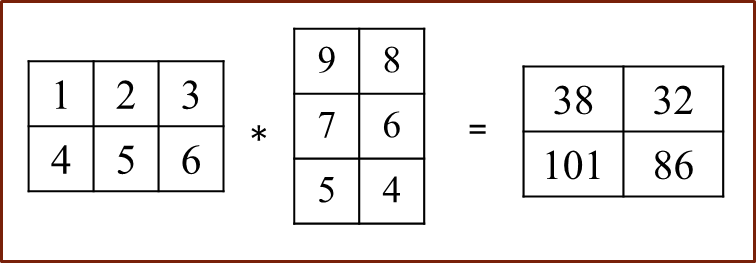

In [37]:
import numpy as np
from numba import cuda
import time

# NumPy 版本
def matrix_multiply_numpy(a, b):
    return np.matmul(a, b)

# CUDA 版本（分塊矩陣乘法，無批次）
@cuda.jit
def matrix_multiply_cuda(a, b, c):
    # 定義區塊大小
    BLOCK_SIZE = 2  # 適應小矩陣，選擇 BLOCK_SIZE=2
    
    # 獲取執行緒和區塊索引
    row = cuda.threadIdx.x  # 區塊內部的行索引（0 到 BLOCK_SIZE-1）
    col = cuda.threadIdx.y  # 區塊內部的列索引（0 到 BLOCK_SIZE-1）
    
    # 計算全局索引
    global_row = cuda.blockIdx.x * BLOCK_SIZE + row  # 範圍：0 到 1（對應 c 的 2 行）
    global_col = cuda.blockIdx.y * BLOCK_SIZE + col  # 範圍：0 到 1（對應 c 的 2 列）
    
    # 檢查是否在矩陣範圍內
    if global_row < c.shape[0] and global_col < c.shape[1]:
        # 分配共享記憶體
        a_shared = cuda.shared.array((BLOCK_SIZE, BLOCK_SIZE), dtype=np.float32)
        b_shared = cuda.shared.array((BLOCK_SIZE, BLOCK_SIZE), dtype=np.float32)
        
        tmp = 0.0
        # 沿著 k 維度分塊（k 是 a 的列數，b 的行數，範圍 0 到 2）
        for block_k in range(0, a.shape[1], BLOCK_SIZE):
            # 載入子矩陣到共享記憶體
            a_shared[row, col] = a[global_row, block_k + col] if block_k + col < a.shape[1] else 0.0
            b_shared[row, col] = b[block_k + row, global_col] if block_k + row < b.shape[0] else 0.0
            
            # 同步執行緒，確保共享記憶體載入完成
            cuda.syncthreads()
            
            # 計算當前塊的貢獻
            for k in range(BLOCK_SIZE):
                tmp += a_shared[row, k] * b_shared[k, col]
            
            # 同步執行緒，準備下一次載入
            cuda.syncthreads()
        
        # 寫入結果
        c[global_row, global_col] = tmp

# 測試程式碼
a = np.array([[1,2,3],
              [4,5,6]])
b= np.array([[9,8],
             [7,6],
             [5,4]])


rows_a, cols_a = a.shape
rows_b, cols_b = b.shape
c = np.zeros((rows_a, cols_b), dtype=np.float32)  # c 的形狀 (2, 2)



# 傳輸到 GPU
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
c_device = cuda.to_device(c)

# 配置網格和區塊
BLOCK_SIZE = 2
block_dim = (BLOCK_SIZE, BLOCK_SIZE)  # 2x2 執行緒
grid_dim = ((rows_a + BLOCK_SIZE - 1) // BLOCK_SIZE, (cols_b + BLOCK_SIZE - 1) // BLOCK_SIZE)  # (1, 1)

# 測試 NumPy 版本
start = time.time()
result_numpy = matrix_multiply_numpy(a, b)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")
print("NumPy 結果:\n", result_numpy)

# 測試 CUDA 版本
start = time.time()
matrix_multiply_cuda[grid_dim, block_dim](a_device, b_device, c_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間: {cuda_time:.4f} 秒")

# 複製結果回主機
result_cuda = c_device.copy_to_host()

print("CUDA 結果:\n", result_cuda)

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda))

NumPy 版本時間: 0.0000 秒
NumPy 結果:
 [[ 38  32]
 [101  86]]
CUDA 版本時間: 0.1584 秒
CUDA 結果:
 [[ 38.  32.]
 [101.  86.]]
結果是否一致: True


c:\Users\glanb\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [38]:
import numpy as np
from numba import cuda
import time

# NumPy 版本
def matrix_multiply_numpy(a, b):
    return np.matmul(a, b)

# CUDA 版本（簡單矩陣乘法，無分塊）
@cuda.jit
def matrix_multiply_cuda_simple(a, b, c):
    # 獲取全局索引（二維）
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x  # 全局行索引
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y  # 全局列索引
    
    # 檢查是否在矩陣範圍內
    if row < c.shape[0] and col < c.shape[1]:
        tmp = 0.0
        # 直接計算矩陣乘法
        for k in range(a.shape[1]):  # k 是 a 的列數，b 的行數
            tmp += a[row, k] * b[k, col]
        c[row, col] = tmp

# 測試程式碼
a = np.array([[1,2,3],
              [4,5,6]])
b= np.array([[9,8],
             [7,6],
             [5,4]])


rows_a, cols_a = a.shape
rows_b, cols_b = b.shape
c = np.zeros((rows_a, cols_b), dtype=np.float32)  # c 的形狀 (2, 2)

# 傳輸到 GPU
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
c_device = cuda.to_device(c)

# 配置網格和區塊
block_dim = (2, 2)  # 2x2 執行緒
grid_dim = (1, 1)  # 網格大小，直接覆蓋 2x2 矩陣

# 測試 NumPy 版本
start = time.time()
result_numpy = matrix_multiply_numpy(a, b)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")
print("NumPy 結果:\n", result_numpy)

# 測試 CUDA 版本
start = time.time()
matrix_multiply_cuda_simple[grid_dim, block_dim](a_device, b_device, c_device)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間: {cuda_time:.4f} 秒")

# 複製結果回主機
result_cuda = c_device.copy_to_host()
print("CUDA 結果:\n", result_cuda)

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda))

NumPy 版本時間: 0.0000 秒
NumPy 結果:
 [[ 38  32]
 [101  86]]
CUDA 版本時間: 0.0918 秒
CUDA 結果:
 [[ 38.  32.]
 [101.  86.]]
結果是否一致: True


c:\Users\glanb\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


#### 範例：2D 卷積，處理圖像數據。


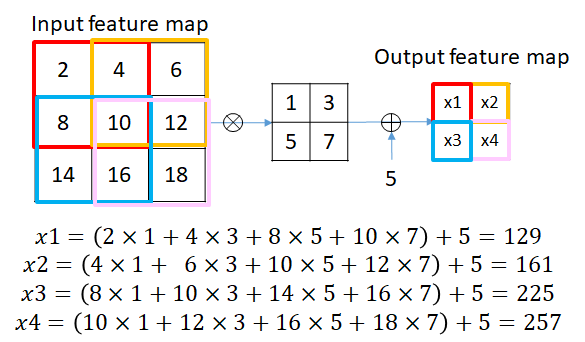

In [39]:
import numpy as np
import time

# 修正後的 NumPy 卷積實現（無零填充）
def convolve_numpy(input, kernel, offset):
    n = input.shape[0]  # 輸入矩陣大小：3x3
    k_size = kernel.shape[0]  # 卷積核大小：2x2
    # 輸出大小：(n - k_size + 1) x (n - k_size + 1)
    out_size = n - k_size + 1  # 3 - 2 + 1 = 2
    output = np.zeros((out_size, out_size), dtype=np.float32)
    
    # 遍歷有效區域
    for i in range(out_size):
        for j in range(out_size):
            tmp = 0.0
            # 卷積核範圍：(0, 0) 到 (1, 1)
            for ki in range(k_size):
                for kj in range(k_size):
                    input_i = i + ki
                    input_j = j + kj
                    tmp += input[input_i, input_j] * kernel[ki, kj]
            output[i, j] = tmp + offset
    return output

# 測試程式碼
n = 3
offset = 5
input = np.array([[ 2,  4,  6],
                  [ 8, 10, 12],
                  [14, 16, 18]]).astype(np.float32)
kernel = np.array([[1, 3],
                   [5, 7]]).astype(np.float32)
print("輸入矩陣:\n", input)
print("卷積核:\n", kernel)

start = time.time()
result_numpy = convolve_numpy(input, kernel, offset)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")
print("修正後結果:\n", result_numpy)

輸入矩陣:
 [[ 2.  4.  6.]
 [ 8. 10. 12.]
 [14. 16. 18.]]
卷積核:
 [[1. 3.]
 [5. 7.]]
NumPy 版本時間: 0.0000 秒
修正後結果:
 [[129. 161.]
 [225. 257.]]


In [40]:
import numpy as np
from numba import cuda
import time


# CUDA 核心：2D 卷積（無零填充，添加偏移量）
@cuda.jit
def convolution_2d_cuda(input, kernel, output, offset, k_size):
    # 獲取全局索引
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    # 檢查是否在輸出範圍內
    if row < output.shape[0] and col < output.shape[1]:
        tmp = 0.0
        # 計算卷積（無零填充）
        for ki in range(k_size):
            for kj in range(k_size):
                input_i = row + ki
                input_j = col + kj
                tmp += input[input_i, input_j] * kernel[ki, kj]
        output[row, col] = tmp + offset  # 加上偏移量

# 測試程式碼
n = 3
input = np.array([[ 2,  4,  6],
                  [ 8, 10, 12],
                  [14, 16, 18]]).astype(np.float32)
kernel = np.array([[1, 3],
                   [5, 7]]).astype(np.float32)
offset = 5  # 偏移量

# 計算輸出大小
k_size = kernel.shape[0] 
out_size = n - k_size + 1  # 2x2
print("輸入矩陣:\n", input)
print("卷積核:\n", kernel)

# 測試 NumPy 版本
start = time.time()
result_numpy = convolve_numpy(input, kernel, offset)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")
print("NumPy 結果:\n", result_numpy)

# 傳輸到 GPU
input_device = cuda.to_device(input)
kernel_device = cuda.to_device(kernel)
output = np.zeros((out_size, out_size), dtype=np.float32)
output_device = cuda.to_device(output)

# 配置網格和區塊
block_dim = (2, 2)  # 2x2 執行緒
grid_dim = (1, 1)   # 網格大小

# 測試 CUDA 版本
start = time.time()
convolution_2d_cuda[grid_dim, block_dim](input_device, kernel_device, output_device, offset, k_size)
cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間: {cuda_time:.4f} 秒")

# 複製結果回主機
result_cuda = output_device.copy_to_host()
print("CUDA 結果:\n", result_cuda)

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda))

輸入矩陣:
 [[ 2.  4.  6.]
 [ 8. 10. 12.]
 [14. 16. 18.]]
卷積核:
 [[1. 3.]
 [5. 7.]]
NumPy 版本時間: 0.0000 秒
NumPy 結果:
 [[129. 161.]
 [225. 257.]]
CUDA 版本時間: 0.0886 秒
CUDA 結果:
 [[129. 161.]
 [225. 257.]]
結果是否一致: True


c:\Users\glanb\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [41]:
import numpy as np
from numba import cuda
import time

# 測試程式碼
n = 1000
k_size = 3  # 卷積核大小：3x3（可改為 5 或其他）
input = np.random.random((n, n)).astype(np.float32)
kernel = np.ones((k_size, k_size), dtype=np.float32) / (k_size * k_size)  # 均值卷積核
offset = 10.0  # 偏移量


# 計算輸出大小
out_size = n - k_size + 1
print(f"\n測試 n={n}")
print("輸入矩陣大小:", input.shape)
print("卷積核大小:", kernel.shape)

# 測試 NumPy 版本
start = time.time()
result_numpy = convolve_numpy(input, kernel, offset)
numpy_time = time.time() - start
print(f"NumPy 版本時間: {numpy_time:.4f} 秒")

# 傳輸到 GPU
input_device = cuda.to_device(input)
kernel_device = cuda.to_device(kernel)
output = np.zeros((out_size, out_size), dtype=np.float32)
output_device = cuda.to_device(output)

# 配置網格和區塊
BLOCK_SIZE = 16
block_dim = (BLOCK_SIZE, BLOCK_SIZE)
grid_dim = ((out_size + BLOCK_SIZE - 1) // BLOCK_SIZE, (out_size + BLOCK_SIZE - 1) // BLOCK_SIZE)

# 測試 CUDA 版本
start = time.time()
convolution_2d_cuda[grid_dim, block_dim](input_device, kernel_device, output_device, offset, k_size)

cuda.synchronize()
cuda_time = time.time() - start
print(f"CUDA 版本時間: {cuda_time:.4f} 秒")

# 複製結果回主機
result_cuda = output_device.copy_to_host()

# 驗證結果
print("結果是否一致:", np.allclose(result_numpy, result_cuda, rtol=1e-4, atol=1e-4))

# 檢查最大誤差
diff = np.abs(result_numpy - result_cuda)
print("最大誤差:", np.max(diff))


測試 n=1000
輸入矩陣大小: (1000, 1000)
卷積核大小: (3, 3)
NumPy 版本時間: 5.9450 秒
CUDA 版本時間: 0.1425 秒
結果是否一致: True
最大誤差: 0.0


### 矩陣乘法記憶體的說明
$$
C=A\times B
$$
$A: (batch, M, K)$<br>
$B: (batch, K, N)$<br>
$C: (batch, M, N)$<br>
$假設 M = 5, N=5, K = 4$<br>



#### 全局記憶體訪問的問題：<br>

全局記憶體（global memory）是 GPU 上存儲 a 和 b 的主要記憶體，但其存取延遲高（通常 400-600 個時鐘週期），是 GPU 計算的瓶頸。<br>

若不使用共享記憶體，執行緒直接從全局記憶體讀取 ```a[batch, global_row, k]``` 和 ```b[batch, k, global_col]```。<br>

每個元素會被重複讀取多次：<br>
```a[batch, global_row, k]``` 被讀取 𝑁 次（5 次）。<br>
```b[batch, k, global_col]``` 被讀取 𝑀 次（5 次）。<br>

總訪問次數：<br>
𝑀×𝐾×𝑁+𝐾×𝑁×𝑀 = 2×𝑀×𝑁×𝐾 = 2×5×5×4= 200 次。<br>

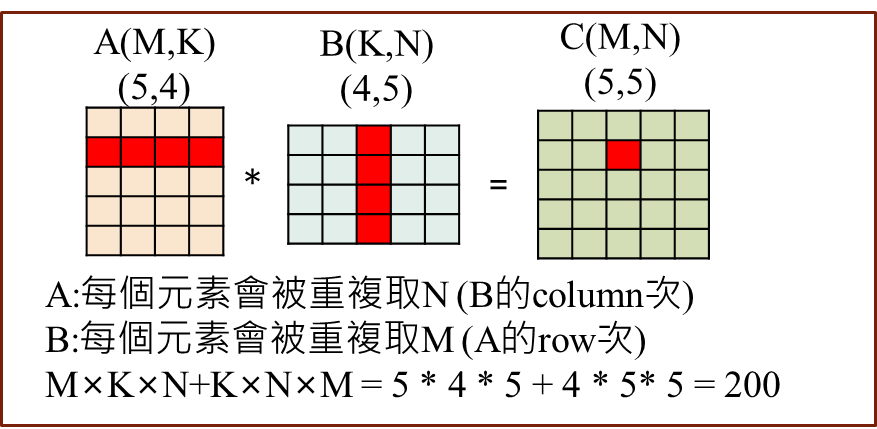


#### 共享記憶體的優化：<br>
低延遲存取（約 1-2 個時鐘週期)<br>

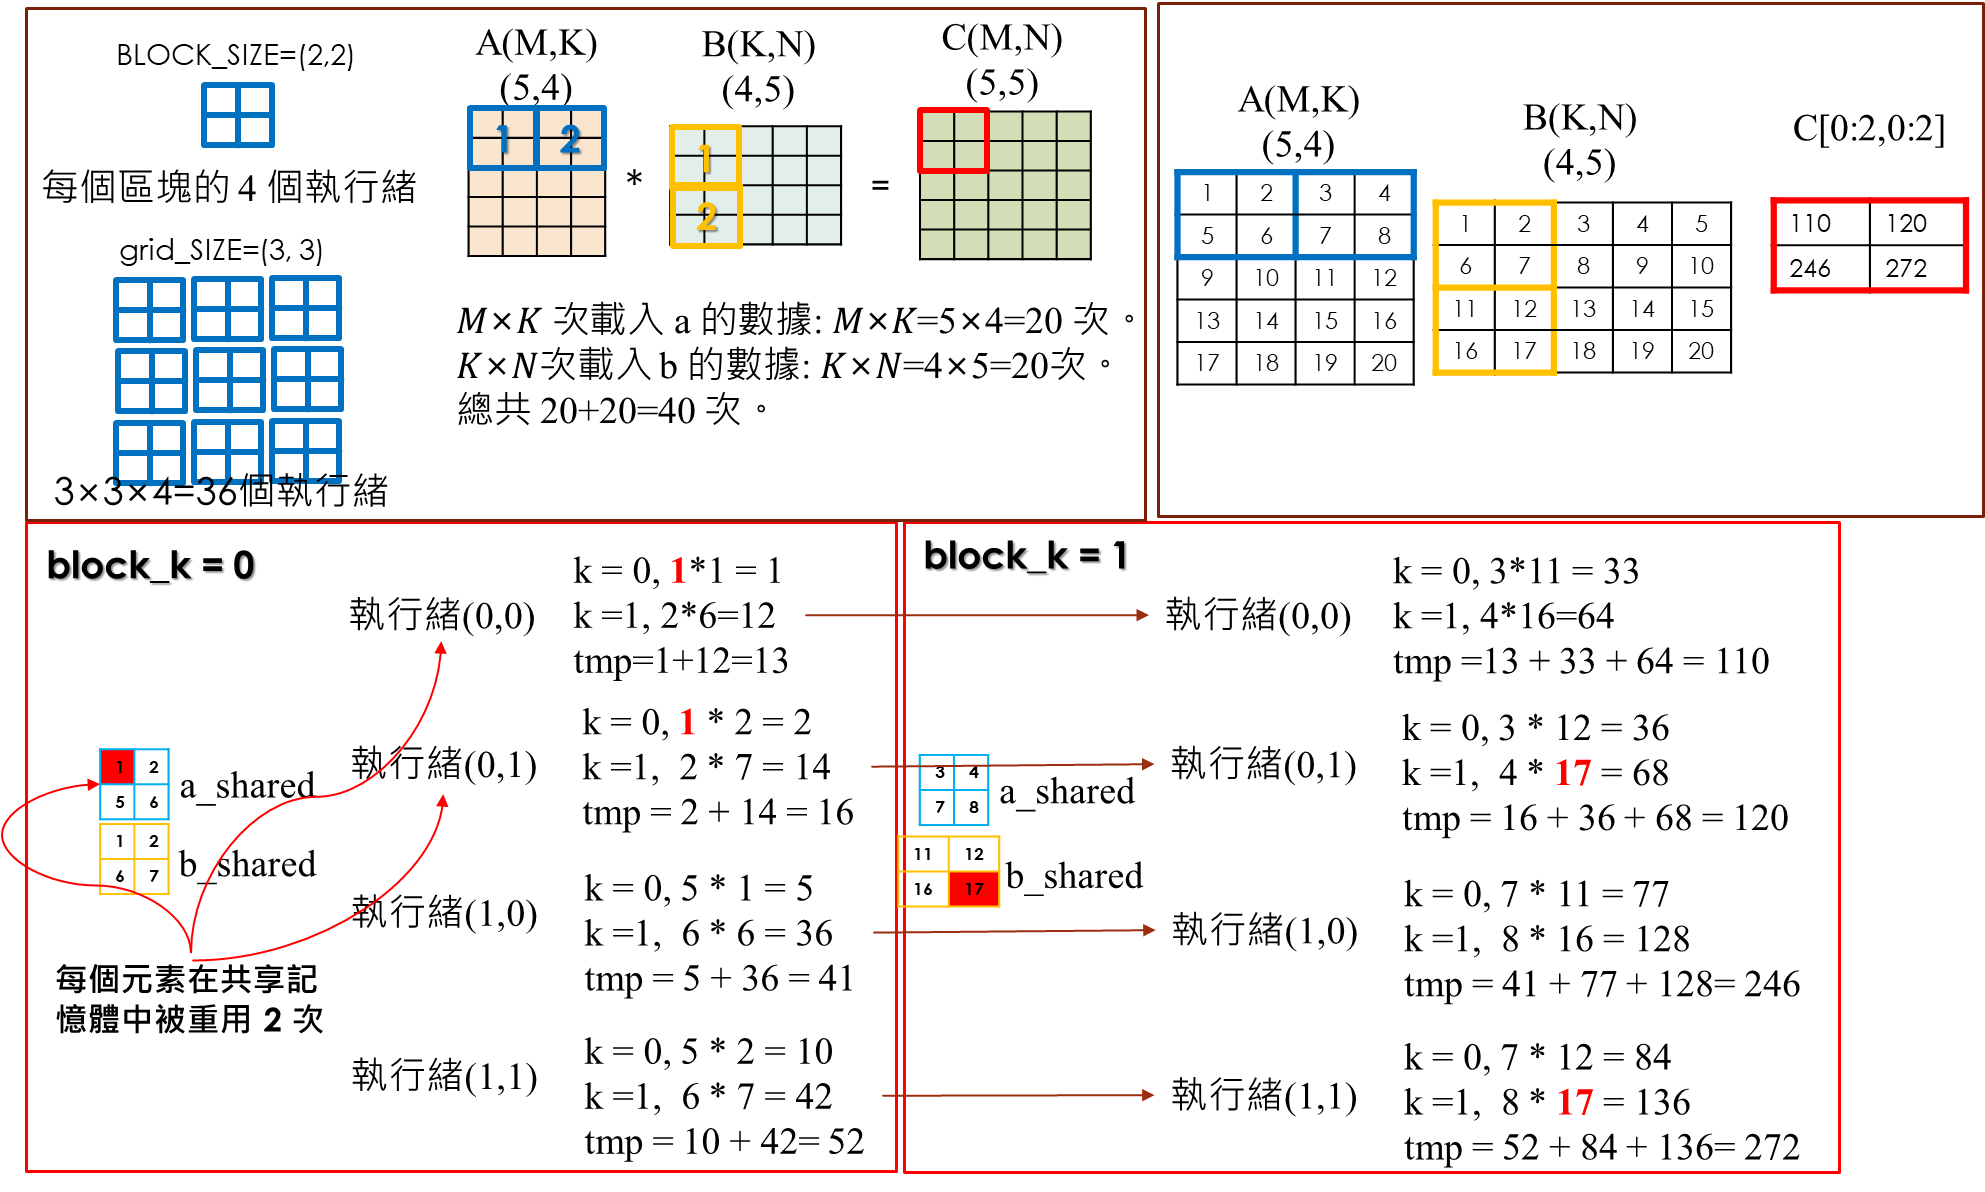


* BLOCK_SIZE = 2 <br>

分塊矩陣乘法，將矩陣沿𝐾 維度分解為2×2 子矩陣，每次迭代處理一個 2×2 子矩陣的部分內積，總共 𝐾/𝐵𝐿𝑂𝐶𝐾𝑆𝐼𝑍𝐸=4/2=2次迭代，計算完整的矩陣乘法。<br>

共享記憶體 a_shared 和 b_shared 暫存子矩陣，形狀為2×2(因為 BLOCK_SIZE = 2）。<br>

每個子矩陣的元素從全局記憶體載入一次，然後存儲在共享記憶體中，供區塊內的執行緒重複使用。<br>

每個區塊的 4 個執行緒協作載入 2×2子矩陣，每次迭代總共 8 次全局記憶體訪問（4 次載入 a_shared，4 次載入 b_shared）。<br>

總共 2 次分塊（因為 𝐾=4，4÷2=2），總訪問次數：<br>
𝑀×𝐾 + 𝐾×𝑁 = 5×4 + 4×5 = 40次。<br>

減少了約 80% 的全局記憶體訪問（從 200 次減少到 40 次）。

容量有限：通常每個區塊的共享記憶體容量為 48KB 或 96KB<br> 
低延遲存取（約 1-2 個時鐘週期，相較全局記憶體的 400-600 週期）<br>

